# -------------Giai đoạn 1: Xử lí dữ liệu-------------

* Khai báo thư viện

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import spacy
from collections import Counter
import io
import os

# 1. Load Tokenizer (Spacy)

In [2]:
!python -m spacy download fr_core_news_sm
spacy_en = spacy.load("en_core_web_sm")
spacy_fr = spacy.load("fr_core_news_sm")

def tokenize_en(text):
    """Tách từ tiếng Anh, đảo ngược nếu cần (nhưng lúc này cứ để xuôi đê)"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """Tách từ tiếng Pháp"""
    return [tok.text.lower() for tok in spacy_fr.tokenizer(text)]

  Using cached https://github.com/explosion/spacy-models/releases/download/fr_core_news_sm-3.8.0/fr_core_news_sm-3.8.0-py3-none-any.whl (16.3 MB)
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# 2. Xây dựng bộ từ vựng (Vocabulary)

In [3]:
class Vocabulary:
    def __init__(self, freq_threshold=2):
        # 4 token đặc biệt bắt buộc phải có
        self.itos = {0: "<unk>", 1: "<pad>", 2: "<sos>", 3: "<eos>"}
        self.stoi = {"<unk>": 0, "<pad>": 1, "<sos>": 2, "<eos>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list, tokenizer):
        frequencies = Counter()
        idx = 4 # Bắt đầu từ 4 vì 0-3 đã dùng cho token đặc biệt

        for sentence in sentence_list:
            for word in tokenizer(sentence):
                frequencies[word] += 1

                # Chỉ thêm từ xuất hiện đủ nhiều (tránh rác)
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text, tokenizer):
        """Chuyển câu text thành list các số (indices)"""
        tokenized_text = tokenizer(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

# 3. Class Dataset Chính

In [4]:
class Multi30kDataset(Dataset):
    def __init__(self, root_dir, mode='train', src_vocab=None, trg_vocab=None):
        self.root_dir = root_dir
        self.mode = mode

        # Đọc file raw
        en_path = os.path.join(root_dir, f'{mode}.en')
        fr_path = os.path.join(root_dir, f'{mode}.fr')

        with open(en_path, 'r', encoding='utf-8') as f:
            self.source_sentences = [line.strip() for line in f.readlines()]

        with open(fr_path, 'r', encoding='utf-8') as f:
            self.target_sentences = [line.strip() for line in f.readlines()]

        # Xây dựng hoặc dùng lại vocab
        if src_vocab is None or trg_vocab is None:
            print(f" Đang xây dựng Vocabulary từ tập {mode}...")
            self.src_vocab = Vocabulary()
            self.trg_vocab = Vocabulary()

            self.src_vocab.build_vocabulary(self.source_sentences, tokenize_en)
            self.trg_vocab.build_vocabulary(self.target_sentences, tokenize_fr)
            print(f" Vocab xong! Tiếng Anh: {len(self.src_vocab)} từ, Tiếng Pháp: {len(self.trg_vocab)} từ.")
        else:
            self.src_vocab = src_vocab
            self.trg_vocab = trg_vocab

    def __len__(self):
        return len(self.source_sentences)

    def __getitem__(self, index):
        src_text = self.source_sentences[index]
        trg_text = self.target_sentences[index]

        # Chuyển text sang số: <sos> ...câu... <eos>
        src_numericalized = [self.src_vocab.stoi["<sos>"]]
        src_numericalized += self.src_vocab.numericalize(src_text, tokenize_en)
        src_numericalized += [self.src_vocab.stoi["<eos>"]]

        trg_numericalized = [self.trg_vocab.stoi["<sos>"]]
        trg_numericalized += self.trg_vocab.numericalize(trg_text, tokenize_fr)
        trg_numericalized += [self.trg_vocab.stoi["<eos>"]]

        return torch.tensor(src_numericalized), torch.tensor(trg_numericalized)

# 4. Hàm Collate (Xử lý Batch - QUAN TRỌNG NHẤT)

In [5]:
class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        # batch là list các cặp (src, trg) từ __getitem__

        # Sắp xếp batch theo độ dài câu nguồn giảm dần (Bắt buộc cho pack_padded_sequence)
        batch.sort(key=lambda x: len(x[0]), reverse=True)

        src_batch, trg_batch = zip(*batch)

        # Padding: thêm số 1 (<pad>) vào cho bằng độ dài
        src_padded = pad_sequence(src_batch, padding_value=self.pad_idx, batch_first=False) # Shape: [src_len, batch_size]
        trg_padded = pad_sequence(trg_batch, padding_value=self.pad_idx, batch_first=False) # Shape: [trg_len, batch_size]

        return src_padded, trg_padded

# --------------GIAI ĐOẠN 2: XÂY DỰNG MODEL------------------

* Khai báo thêm thư viện

In [6]:
import torch
import torch.nn as nn
import random
import torch.nn.functional as F

# 1. Mã hóa lớp Encoder

In [7]:
# 1. ENCODER
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)

        # encode context vectors
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [src len, batch size]

        embedded = self.dropout(self.embedding(src))
        # embedded: [src len, batch size, emb dim]

        # outputs: chứa toàn bộ hidden states của từng từ (cần cho Attention)
        # hidden, cell: trạng thái cuối cùng (cần để khởi tạo Decoder)
        outputs, (hidden, cell) = self.rnn(embedded)

        # --- Phải trả về cả outputs ---
        return outputs, hidden, cell

# 2. ATTENTION
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        # Input của lớp Linear là kết hợp của (hidden_decoder + encoder_output)
        self.attn = nn.Linear(hid_dim * 2, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [n_layers, batch size, hid dim] (Lấy từ Decoder)
        # encoder_outputs: [src len, batch size, hid dim]

        # --- QUAN TRỌNG: Chỉ lấy hidden state của lớp cuối cùng ---
        # Nếu n_layers > 1, hidden có shape [n_layers, ...]. Ta chỉ cần lớp cuối [1, ...]
        if hidden.dim() == 3:
            hidden = hidden[-1] # Lấy lớp cuối: [batch size, hid dim]

        # src_len = độ dài câu nguồn
        src_len = encoder_outputs.shape[0]

        # Lặp lại hidden state của decoder cho khớp độ dài câu nguồn để tính toán song song
        # hidden: [batch size, hid dim] -> [src len, batch size, hid dim]
        hidden = hidden.unsqueeze(0).repeat(src_len, 1, 1)

        # Tính năng lượng (Energy) - độ tương đồng
        # cat theo chiều cuối (dim=2) -> [src len, batch size, hid dim * 2]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Tính điểm (Attention scores)
        # attention: [src len, batch size, 1]
        attention = self.v(energy).squeeze(2)

        # Softmax để chuẩn hóa thành xác suất (tổng bằng 1 theo chiều dọc - src len)
        # return: [src len, batch size]
        return F.softmax(attention, dim=0)

# 2. Giải mã (Decoder)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src: [src len, batch size]
        embedded = self.dropout(self.embedding(src))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs, hidden, cell

# 3. DECODER ATTENTION (ĐÃ SỬA LỖI DIMENSION)
class Decoder_Attention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(emb_dim + hid_dim + hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell, encoder_outputs):
        # input: [1, batch size]
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        # a = [src len, batch size]
        a = self.attention(hidden, encoder_outputs)

        # --- KHẮC PHỤC LỖI Ở ĐÂY ---
        # Muốn nhân ma trận, a phải có dạng [batch size, 1, src len]
        a = a.permute(1, 0).unsqueeze(1)

        # encoder_outputs = [batch size, src len, hid dim]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # weighted = [batch size, 1, hid dim]
        weighted = torch.bmm(a, encoder_outputs)

        # weighted = [1, batch size, hid dim]
        weighted = weighted.permute(1, 0, 2)

        # Ghép embedding của từ hiện tại với context vector (weighted)
        rnn_input = torch.cat((embedded, weighted), dim=2)

        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))

        # Dự đoán từ tiếp theo
        pred_input = torch.cat((embedded.squeeze(0), output.squeeze(0), weighted.squeeze(0)), dim=1)
        prediction = self.fc_out(pred_input)

        return prediction, hidden, cell

# 3. Tạo mô hình Seq2Seq kết hợp Encoder và Decoder

In [9]:
class MyTranslationModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src len, batch size]
        # trg = [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # encoder_outputs = [src len, batch size, hid dim * 2] (nếu là Bi-LSTM, nếu không thì hid dim * 1)
        # Vì Encoder của mình là đơn hướng (1 chiều), nên hid_dim thôi
        encoder_outputs, hidden, cell = self.encoder(src)

        input = trg[0, :] # Lấy token <sos> đầu tiên

        for t in range(1, trg_len):
            # Truyền thêm encoder_outputs
            output, hidden, cell = self.decoder(input, hidden, cell, encoder_outputs)

            outputs[t] = output

            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)

            input = trg[t] if teacher_force else top1

        return outputs

# --- TEST THỬ MODEL ---

In [10]:
if __name__ == "__main__":
    # Giả lập tham số
    INPUT_DIM = 1000
    OUTPUT_DIM = 1000
    ENC_EMB_DIM = 256
    DEC_EMB_DIM = 256
    HID_DIM = 512
    N_LAYERS = 2
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Khởi tạo Attention (cần thiết cho Decoder_Attention)
    attn = Attention(HID_DIM)

    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    # Sửa từ Decoder thành Decoder_Attention và thêm tham số attention
    dec = Decoder_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
    model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE)

    # Giả lập input (như output của Dataset nãy chạy)
    src = torch.randint(0, 1000, (24, 32)).to(DEVICE) # [Src Len, Batch Size]
    trg = torch.randint(0, 1000, (26, 32)).to(DEVICE) # [Trg Len, Batch Size]

    print(" Đang chạy thử model qua 1 vòng forward...")
    output = model(src, trg)
    print(f" Output Shape: {output.shape}")
    # Mong đợi: [26, 32, 1000] -> [Trg Len, Batch Size, Output Dim]

 Đang chạy thử model qua 1 vòng forward...
 Output Shape: torch.Size([26, 32, 1000])


# Code full train và đánh giá model trong model_train.ipynb

* Khai báo thư viện

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

* CẤU HÌNH (CONFIG)

In [12]:
DATA_DIR = "./data_clean" # Folder chứa data chuẩn
BATCH_SIZE = 128         # Mượn gpu t4 của google collab
N_EPOCHS = 10           # Chạy thử 5-10 epoch xem sao
CLIP = 1.0              # Cắt gradient để không bị lỗi
LR = 0.001              # Tốc độ học
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Đang chạy trên: {DEVICE}")

 Đang chạy trên: cuda


# 1. CHUẨN BỊ DỮ LIỆU

In [13]:
print(" Đang load dữ liệu...")
train_dataset = Multi30kDataset(DATA_DIR, mode='train')
val_dataset = Multi30kDataset(DATA_DIR, mode='val', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)
# test_dataset = Multi30kDataset(DATA_DIR, mode='test', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)

pad_idx = train_dataset.src_vocab.stoi["<pad>"]

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx), num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx), num_workers=0)

print(f" Data ngon lành! Train: {len(train_dataset)}, Val: {len(val_dataset)}")


 Đang load dữ liệu...
 Đang xây dựng Vocabulary từ tập train...
 Vocab xong! Tiếng Anh: 5893 từ, Tiếng Pháp: 6470 từ.
 Data ngon lành! Train: 29000, Val: 1014


# 2. KHỞI TẠO MODEL

In [14]:
INPUT_DIM = len(train_dataset.src_vocab)
OUTPUT_DIM = len(train_dataset.trg_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# Khởi tạo Attention
attn = Attention(HID_DIM)

# Encoder giữ nguyên
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)

# Decoder Attention
dec = Decoder_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

# Gán vào Seq2Seq
model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE)

# Khởi tạo trọng số (Weight Initialization) - Giúp model học nhanh hơn
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LR)
# Bỏ qua loss của token <pad>
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# 3. HÀM TRAIN & EVALUATE

In [15]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()

        # output: [trg len, batch size, output dim]
        output = model(src, trg)

        output_dim = output.shape[-1]

        # Bỏ token <sos> đầu tiên khi tính loss
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Clip gradient để tránh bùng nổ
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

        # Log nhẹ cái để biết máy không bị treo (mỗi 50 batch báo 1 lần)
        if i % 50 == 0:
            print(f"   Batch {i}/{len(iterator)} | Loss: {loss.item():.3f}")

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg, teacher_forcing_ratio=0) # Tắt teacher forcing khi val/test
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# 4. HÀM DỊCH THỬ

In [16]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len=50):
    model.eval()

    # 1. Tokenize & Numericalize
    if isinstance(sentence, str):
        import spacy
        spacy_en = spacy.load("en_core_web_sm")
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = ["<sos>"] + tokens + ["<eos>"]
    src_indexes = [src_vocab.stoi.get(token, src_vocab.stoi["<unk>"]) for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device) # [len, 1]

    with torch.no_grad():
        # Encoder returns outputs, hidden, cell
        encoder_outputs, hidden, cell = model.encoder(src_tensor)

    # Decoder
    trg_indexes = [trg_vocab.stoi["<sos>"]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device) # [1]

        with torch.no_grad():
            # Decoder_Attention expects input, hidden, cell, encoder_outputs
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell, encoder_outputs)

        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab.stoi["<eos>"]:
            break

    trg_tokens = [trg_vocab.itos[i] for i in trg_indexes]
    return trg_tokens[1:-1] # Bỏ sos, eos

# 5. VÒNG LẶP CHÍNH (MAIN LOOP)

 Đang đọc dữ liệu từ data_clean...
 Đang xây dựng Vocabulary từ tập train...
 Vocab xong! Tiếng Anh: 5893 từ, Tiếng Pháp: 6470 từ.
 Số lượng câu Train: 29000
 Số lượng câu Val:   1014
 Vocab Size: Anh=5893, Pháp=6470

 Bắt đầu Train 10 epochs (Model Attention)...
   Batch 0/227 | Loss: 8.775
   Batch 50/227 | Loss: 5.125
   Batch 100/227 | Loss: 4.826
   Batch 150/227 | Loss: 4.824
   Batch 200/227 | Loss: 4.439
     Đã lưu model tốt nhất (Val Loss: 5.080)
Epoch: 01 | Time: 1m 35s
	Train Loss: 4.978 | Val. Loss: 5.080
   Batch 0/227 | Loss: 4.352
   Batch 50/227 | Loss: 4.390
   Batch 100/227 | Loss: 4.097
   Batch 150/227 | Loss: 4.089
   Batch 200/227 | Loss: 3.826
     Đã lưu model tốt nhất (Val Loss: 4.772)
Epoch: 02 | Time: 1m 34s
	Train Loss: 4.225 | Val. Loss: 4.772
   Batch 0/227 | Loss: 3.963
   Batch 50/227 | Loss: 4.122
   Batch 100/227 | Loss: 3.738
   Batch 150/227 | Loss: 3.715
   Batch 200/227 | Loss: 3.584
     Đã lưu model tốt nhất (Val Loss: 4.511)
Epoch: 03 | Time: 1

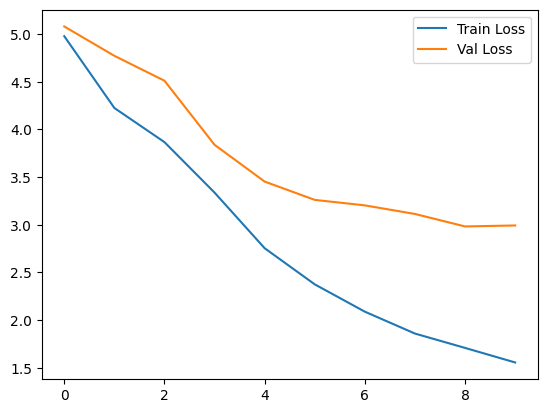


 Dịch thử 1 câu:
Src: A man is walking a dog.
Trg: un homme promène un chien .


In [17]:
if __name__ == "__main__":
    import os

    # 1. CẤU HÌNH
    DATA_DIR = "data_clean"

    # --- KIỂM TRA AN TOÀN ---
    if not os.path.exists(os.path.join(DATA_DIR, 'train.en')):
        print(" LỖI TO: Không tìm thấy file dữ liệu!")
        exit()

    # 2. Load Dataset
    print(f" Đang đọc dữ liệu từ {DATA_DIR}...")
    train_dataset = Multi30kDataset(DATA_DIR, mode='train')
    val_dataset = Multi30kDataset(DATA_DIR, mode='val', src_vocab=train_dataset.src_vocab, trg_vocab=train_dataset.trg_vocab)

    print(f" Số lượng câu Train: {len(train_dataset)}")
    print(f" Số lượng câu Val:   {len(val_dataset)}")
    print(f" Vocab Size: Anh={len(train_dataset.src_vocab)}, Pháp={len(train_dataset.trg_vocab)}")

    # 3. Setup DataLoader
    pad_idx = train_dataset.src_vocab.stoi["<pad>"]
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=Collate(pad_idx), num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=Collate(pad_idx), num_workers=0)

    # 4. KHỞI TẠO MODEL (PHẦN QUAN TRỌNG ĐÃ SỬA)
    INPUT_DIM = len(train_dataset.src_vocab)
    OUTPUT_DIM = len(train_dataset.trg_vocab)

    # --- KHỞI TẠO ATTENTION ---
    attn = Attention(HID_DIM)

    # --- DÙNG DECODER_ATTENTION THAY VÌ DECODER THƯỜNG ---
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder_Attention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)

    # --- GÁN VÀO SEQ2SEQ ---
    model = MyTranslationModel(enc, dec, DEVICE).to(DEVICE) # Hoặc Seq2Seq nếu bạn đã đổi tên class

    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

    # 5. Bắt đầu Train
    best_valid_loss = float('inf')
    train_losses = []
    val_losses = []

    print(f"\n Bắt đầu Train {N_EPOCHS} epochs (Model Attention)...")

    for epoch in range(N_EPOCHS):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, CLIP)
        valid_loss = evaluate(model, val_loader, criterion)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"     Đã lưu model tốt nhất (Val Loss: {valid_loss:.3f})")

        print(f'Epoch: {epoch+1:02} | Time: {int(epoch_mins)}m {int(epoch_secs)}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

    # 6. Vẽ biểu đồ & Test
    print("\n Đang vẽ biểu đồ Loss...")
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.savefig('loss_chart.png')
    plt.show()

    model.load_state_dict(torch.load('best_model.pth'))
    print("\n Dịch thử 1 câu:")
    sentence = "A man is walking a dog."
    translation = translate_sentence(sentence, train_dataset.src_vocab, train_dataset.trg_vocab, model, DEVICE)
    print(f"Src: {sentence}")
    print(f"Trg: {' '.join(translation)}")

# TÍNH ĐIỂM BLEU TRÊN TẬP TEST

In [26]:
from nltk.translate.bleu_score import corpus_bleu
import spacy

# Load lại Spacy để chắc chắn nó tồn tại
try:
    spacy_fr = spacy.load("fr_core_news_sm")
except:
    print(" Đang tải lại model tiếng Pháp...")
    import os
    os.system("python -m spacy download fr_core_news_sm")
    spacy_fr = spacy.load("fr_core_news_sm")

def calculate_bleu_score(data_dir, src_vocab, trg_vocab, model, device):
    print(f" Đang load tập Test từ {data_dir}...")
    # Load tập test (chưa từng dùng train)
    test_dataset = Multi30kDataset(data_dir, mode='test', src_vocab=src_vocab, trg_vocab=trg_vocab)
    print(f" Số lượng câu Test: {len(test_dataset)}")

    trgs = []
    pred_trgs = []

    model.eval()

    print(" Đang dịch và chấm điểm (Chờ tí nhé)...")

    # Chạy vòng lặp dịch từng câu
    for i in range(len(test_dataset)):
        # Lấy câu gốc dạng text
        src_text = test_dataset.source_sentences[i] # Tiếng Anh
        trg_text = test_dataset.target_sentences[i] # Tiếng Pháp (Đáp án)

        # Model dịch
        pred_tokens = translate_sentence(src_text, src_vocab, trg_vocab, model, device)

        # --- SỬA LỖI Ở ĐÂY ---
        # Dùng t.text.lower() thay vì t.lower()
        trg_tokens = [t.text.lower() for t in spacy_fr.tokenizer(trg_text)]

        pred_trgs.append(pred_tokens)
        trgs.append([trg_tokens])

        # In thử 3 câu đầu xem nó dịch đúng không
        if i < 3:
            print(f"\n--- Ví dụ {i+1} ---")
            print(f"Src:  {src_text}")
            print(f"Real: {trg_text}")
            print(f"Pred: {' '.join(pred_tokens)}")

    # Tính điểm BLEU
    score = corpus_bleu(trgs, pred_trgs) * 100
    print(f"\n BLEU SCORE TRÊN TẬP TEST: {score:.2f}")
    return score

# CHẠY TÍNH ĐIỂM

In [ ]:
if __name__ == "__main__":
    # Đảm bảo đã load model tốt nhất
    if os.path.exists('best_model.pth'):
        model.load_state_dict(torch.load('best_model.pth'))
        print(" Đã load model 'best_model.pth'")
    else:
        print(" Không tìm thấy file model! Hãy train trước đã.")

    # Gọi hàm (Không cần truyền spacy tokenizer vào nữa, hàm tự lo)
    bleu = calculate_bleu_score(DATA_DIR, train_dataset.src_vocab, train_dataset.trg_vocab, model, DEVICE)

    if bleu > 30:
        print(" Đánh giá: Model SIÊU CẤP (A+)")
    elif bleu > 20:
        print(" Đánh giá: Model XỊN (Điểm A)")
    elif bleu > 10:
        print(" Đánh giá: Model TẠM ỔN (Qua môn)")
    else:
        print(" Đánh giá: Model hơi yếu")

 Đã load model 'best_model.pth'
 Đang load tập Test từ data_clean...
 Số lượng câu Test: 1000
 Đang dịch và chấm điểm (Chờ tí nhé)...

--- Ví dụ 1 ---
Src:  A man in an orange hat starring at something.
Real: Un homme avec un chapeau orange regardant quelque chose.
Pred: un homme avec un chapeau orange regarde quelque chose .

--- Ví dụ 2 ---
Src:  A Boston Terrier is running on lush green grass in front of a white fence.
Real: Un terrier de Boston court sur l'herbe verdoyante devant une clôture blanche.
Pred: un nageur <unk> court sur l' herbe verte devant un clôture blanche .

--- Ví dụ 3 ---
Src:  A girl in karate uniform breaking a stick with a front kick.
Real: Une fille en tenue de karaté brisant un bâton avec un coup de pied.
Pred: une fille en tenue de karaté , un un avec un bras .

 BLEU SCORE TRÊN TẬP TEST: 39.32
 Đánh giá: Model SIÊU CẤP (A+)
